In [1]:
import sys
sys.path.append('../..')
sys.path.append('../')
from datasets import load_dataset, load_dataset_builder
import lightning as L

from astropile.utils import cross_match_datasets
from photo_z_data_wrapper import PhotoZWrapper
from photo_z_models import SimpleCNN, TrainingOnlyProgressBar
from utils import split_dataset

/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /mnt/sw/nix/store/7bjp92vyxq4vmcm6q2kwdv325d50n362-py-torchvision-0.14.1/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [4]:
# Decide on image and spectrum datasets
image_dataset = 'hsc'
spectrum_dataset = 'sdss'

# Load Dataset Builders 
image_builder = load_dataset_builder(f'/mnt/ceph/users/polymathic/AstroPile_tiny/{image_dataset}/{image_dataset}.py', trust_remote_code=True)
spectrum_builder = load_dataset_builder(f'/mnt/ceph/users/polymathic/AstroPile_tiny/{spectrum_dataset}/{spectrum_dataset}.py', trust_remote_code=True)

# Cross-Match Datasets with AstroPile
cross_matched_dset = cross_match_datasets(image_builder, spectrum_builder,
                                      matching_radius=1.0,
                                      keep_in_memory=True,
                                      )

# You have to tell the cross-matched dataset which format you want to use
cross_matched_dset.set_format('torch')

Initial number of matches:  102
Number of matches lost at healpix region borders:  0
Final size of cross-matched catalog:  102


Generating train split: 0 examples [00:00, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

In [ ]:
# Use prebuilt split function to split the dataset (currently supports naive)
train_dataset, test_dataset = split_dataset(cross_matched_dset, split='naive')

In [4]:
# Create PhotoZWrapper for training and testing
photo_z = PhotoZWrapper(
    train_dataset,
    test_dataset, 
    feature_flag='image.array', # feature flag
    label_flag='Z',             # label flag
    feature_dynamic_range=True,
    label_dynamic_range=False,
    feature_z_score=True,
    label_z_score=True,
    loading='iterated',         # iterated or full
    batch_size=128, 
    num_workers=16, 
    val_size=0.1, 
    )    

# Create SimpleCNN model
model = SimpleCNN(
    input_channels=5,           # HSC images have 5 channels
    layer_width=32,             
    num_layers=5, 
    num_classes=1,              # Regressing redshift so only 1 class
    learning_rate=5e-3
    )

In [5]:
import lightning as L

# Set up saving checkpoints 
Checkpointing = L.pytorch.callbacks.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    )

# Set up the training class
trainer = L.Trainer(
    max_epochs=30,
    accelerator='gpu', 
    logger=True, 
    callbacks=[
        TrainingOnlyProgressBar(), 
        Checkpointing
        ],
    enable_checkpointing=True,
    fast_dev_run=False,
    )

/mnt/home/lparker/python_envs/astrokernel/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
# Fit the trainer on the model
trainer.fit(model=model, datamodule=photo_z)

/mnt/home/lparker/python_envs/astrokernel/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-p ...
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | conv_layers     | Sequential        | 38.5 K
1 | global_avg_pool | AdaptiveAvgPool2d | 0     
2 | fc              | Linear            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/mnt/home/lparker/python_envs/astrokernel/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [7]:
# Load the best model from the checkpoint
model = SimpleCNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

In [8]:
import numpy as np
from sklearn.metrics import r2_score

# Get R^2 values
model.eval()

y, y_hat = [], []
for batch in photo_z.test_dataloader():
    x, y_true = batch
    y_pred = model(x.cuda()).detach().cpu().numpy()
    y.append(y_true)
    y_hat.append(y_pred)

y, y_hat = np.concatenate(y), np.concatenate(y_hat)
r2 = r2_score(y,y_hat)
mse = np.mean((y-y_hat)**2)

print(f"R^2: {r2}, MSE: {mse}")

R^2: 0.5063123455773337, MSE: 0.5028639435768127


In [229]:
from photo_z_models import NormalizingFlow

# Create NormalizingFlow model
nf = NormalizingFlow(
    model, 
    feature_size=32, 
    num_classes=1, 
    num_flows=4, 
    hidden_dims=[32], 
    lr=1e-3
    )

/mnt/home/lparker/python_envs/astrokernel/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'FeatureExtractor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['FeatureExtractor'])`.


In [230]:
import lightning as L

# Set up saving checkpoints 
Checkpointing = L.pytorch.callbacks.ModelCheckpoint(
    monitor='val_nll',
    mode='min',
    save_top_k=1,
    )

# Set up the training class
trainer = L.Trainer(
    max_epochs=30,
    accelerator='gpu', 
    logger=True, 
    callbacks=[
        TrainingOnlyProgressBar(), 
        Checkpointing
        ],
    enable_checkpointing=True,
    fast_dev_run=False,
    )

/mnt/home/lparker/python_envs/astrokernel/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [232]:
# Fit the trainer on the model
trainer.fit(model=nf, datamodule=photo_z)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                 | Params
-----------------------------------------------------------
0 | feature_extractor | SimpleCNN            | 38.5 K
1 | flow              | ConditionalFlowStack | 7.3 K 
-----------------------------------------------------------
7.3 K     Trainable params
38.5 K    Non-trainable params
45.8 K    Total params
0.183     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/mnt/home/lparker/python_envs/astrokernel/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [233]:
# Load the best model from the checkpoint
model = NormalizingFlow.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

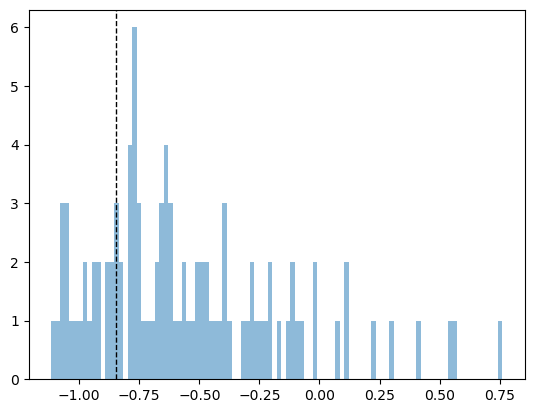

In [253]:
import matplotlib.pyplot as plt

x, y = next(iter(photo_z.test_dataloader()))
random_idx = np.random.randint(0, x.shape[0])

samples = model.single_sample(x[random_idx].cuda()).detach().cpu().numpy()

plt.hist(samples, bins=100, alpha=0.5, label='Single Sample')
plt.axvline(y[random_idx], color='k', linestyle='dashed', linewidth=1, label='True Value')